In [1]:
# Importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

## 1. Data Exploration

#### Dataset

In [2]:
# Set the directory paths for the dataset
train_dir = "chest_xray/train/"
test_dir = "chest_xray/test/"
val_dir = "chest_xray/val/"

In [3]:
# Explore distribution of the data
def explore_data(directory):
    categories = ["Normal", "Pneumonia"]
    for category in categories:
        path = os.path.join(directory, category)
        print(f"{category}: {len(os.listdir(path))} images")


explore_data(train_dir)

Normal: 1341 images
Pneumonia: 3875 images


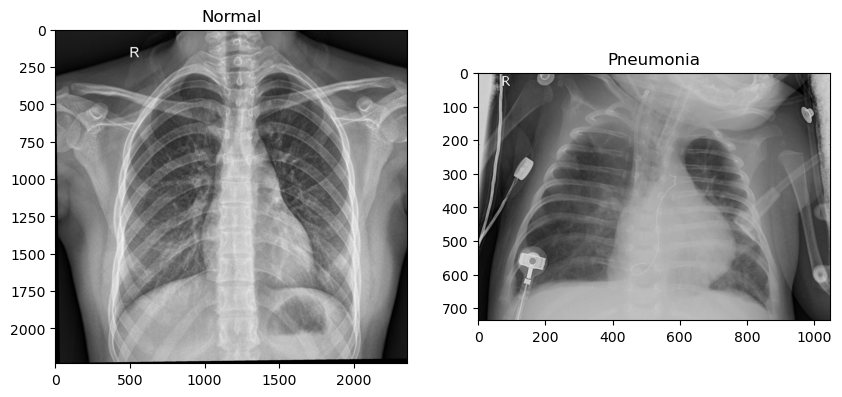

In [4]:
# Visualize sample images
def plot_sample_images(directory):
    categories = ["Normal", "Pneumonia"]
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    for i, category in enumerate(categories):
        path = os.path.join(directory, category)
        image_path = os.listdir(path)[0]
        img = plt.imread(os.path.join(path, image_path))
        axes[i].imshow(img, cmap='grey')
        axes[i].set_title(category)
    plt.show()

plot_sample_images(train_dir)

## 2. Preprocessing

In [5]:
# ImageDataGenerator for Augmentation and Normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=20,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale = 1.0/255.0)
test_datagen = ImageDataGenerator(rescale = 1.0/255.0)

In [6]:
# Flow images from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

test_generator  = test_datagen.flow_from_directory(
    test_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (224,224),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


## 3. Model Development

In [7]:
# Create a sequential model
model = Sequential()

In [8]:
# 1st Convolutional Block
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(BatchNormalization())  
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# 2nd Convolutional Block
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# 3rd Convolutional Block
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# 4th Convolutional Block
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# 5th Convolutional Block
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  
model.add(MaxPooling2D((2, 2)))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())  
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(BatchNormalization())  
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

2024-08-18 16:10:51.346861: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2024-08-18 16:10:51.346896: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-18 16:10:51.346939: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-18 16:10:51.346985: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-18 16:10:51.347006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
# Display a summary of the model architecture, including the number of parameters in each layer
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 56, 56, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 28, 28, 512)    │         2,04

 Total params: 134,314,305 (512.37 MB)

 Trainable params: 134,289,473 (512.27 MB)

 Non-trainable params: 24,832 (97.00 KB)

In [10]:
# Compile the Model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

## 4. Training

In [11]:
history = model.fit(
    train_generator,
    steps_per_epoch = 80,
    validation_data=val_generator,
    epochs=25
)

Epoch 1/25


2024-08-18 16:11:00.624402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.7233 - loss: 1.5402 - val_accuracy: 0.5000 - val_loss: 3.0450
Epoch 2/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.8971 - loss: 0.3151 - val_accuracy: 0.5000 - val_loss: 4.4361
Epoch 3/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.8264 - loss: 0.6097

2024-08-18 16:15:18.007388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:15:18.007414: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:15:18.007423: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6048083911072612402
2024-08-18 16:15:18.007428: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7933007856090972200
2024-08-18 16:15:18.007446: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_354]]
2024-08-18 16:15:18.007451: I tensorflow/core/framewo

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.8230 - loss: 0.4826 - val_accuracy: 0.5000 - val_loss: 3.0446
Epoch 4/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 122s 1s/step - accuracy: 0.8662 - loss: 0.4552 - val_accuracy: 0.5000 - val_loss: 2.0195
Epoch 5/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.8961 - loss: 0.2799 - val_accuracy: 0.5000 - val_loss: 7.6433
Epoch 6/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:54 1s/step - accuracy: 0.9236 - loss: 0.1866

2024-08-18 16:19:23.727732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:19:23.727767: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:19:23.727770: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14822426377791861078
2024-08-18 16:19:23.727773: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14602278667795455756
2024-08-18 16:19:23.727817: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6048083911072612402
2024-08-18 16:19:23.727830: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 14328488188430693740
2024-08-18 16:19:23.727836: I tensorflow/core/framework/local_rendez

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.9270 - loss: 0.1789 - val_accuracy: 0.5000 - val_loss: 6.1724
Epoch 7/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9120 - loss: 0.2283 - val_accuracy: 0.5000 - val_loss: 2.7658
Epoch 8/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9026 - loss: 0.2647 - val_accuracy: 0.5000 - val_loss: 10.0212
Epoch 9/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9062 - loss: 0.1782

2024-08-18 16:23:24.228420: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:23:24.228499: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:23:24.228571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1/Add/_272]]
2024-08-18 16:23:24.228585: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 13830970003376109594
2024-08-18 16:23:24.228590: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5896919866107215016
2024-08-18 16:23:24.228593: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9062 - loss: 0.2092 - val_accuracy: 0.5000 - val_loss: 7.7481
Epoch 10/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9334 - loss: 0.1680 - val_accuracy: 0.5000 - val_loss: 1.1438
Epoch 11/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9328 - loss: 0.2005 - val_accuracy: 0.4375 - val_loss: 3.2975
Epoch 12/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9861 - loss: 0.0679

2024-08-18 16:27:23.940840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:27:23.940856: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7933007856090972200
2024-08-18 16:27:23.940860: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_112/_162]]
2024-08-18 16:27:23.940864: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 5973311421096215237
2024-08-18 16:27:23.940869: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 10000406486158198503
2024-08-18 16:27:23.940873: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6265909

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9594 - loss: 0.1199 - val_accuracy: 0.4375 - val_loss: 2.8889
Epoch 13/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9334 - loss: 0.1889 - val_accuracy: 0.5000 - val_loss: 2.3772
Epoch 14/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9440 - loss: 0.1627 - val_accuracy: 0.5000 - val_loss: 1.3755
Epoch 15/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9462 - loss: 0.1695

2024-08-18 16:31:25.762353: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:31:25.762442: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add_84/_256]]
2024-08-18 16:31:25.762458: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:31:25.762461: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6048083911072612402
2024-08-18 16:31:25.762464: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11766689761498726750
2024-08-18 16:31:25.762468: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 63344589

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9178 - loss: 0.2261 - val_accuracy: 0.5000 - val_loss: 1.8733
Epoch 16/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9428 - loss: 0.1601 - val_accuracy: 0.5000 - val_loss: 28.1247
Epoch 17/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 117s 1s/step - accuracy: 0.9405 - loss: 0.1457 - val_accuracy: 0.5000 - val_loss: 2.7796
Epoch 18/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9080 - loss: 0.2074

2024-08-18 16:35:26.873624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:35:26.873660: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:35:26.873665: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6048083911072612402
2024-08-18 16:35:26.873677: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3015238882749088618
2024-08-18 16:35:26.873695: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3856335382512338286
2024-08-18 16:35:26.873704: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/adam/Add

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.8963 - loss: 0.2386 - val_accuracy: 0.5000 - val_loss: 3.0393
Epoch 19/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9292 - loss: 0.1951 - val_accuracy: 0.6250 - val_loss: 1.0394
Epoch 20/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - accuracy: 0.9391 - loss: 0.1572 - val_accuracy: 0.5000 - val_loss: 1.6870
Epoch 21/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:51 1s/step - accuracy: 0.9583 - loss: 0.1531

2024-08-18 16:39:27.967405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:39:27.967507: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/sequential_1/dropout_1_2/stateless_dropout/stateless_random_uniform/StatelessRandomGetKeyCounter/_354]]
2024-08-18 16:39:27.967522: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:39:27.967528: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6505586461376707048
2024-08-18 16:39:27.967536: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4933616457362090684
2024-08-18 16:39:27.967541: I tensorflow/core/framewo

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9383 - loss: 0.1760 - val_accuracy: 0.6250 - val_loss: 1.3095
Epoch 22/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.9385 - loss: 0.1619 - val_accuracy: 0.5000 - val_loss: 1.8856
Epoch 23/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9481 - loss: 0.1430 - val_accuracy: 0.5000 - val_loss: 7.7418
Epoch 24/25
 3/80 ━━━━━━━━━━━━━━━━━━━━ 1:52 1s/step - accuracy: 0.9601 - loss: 0.0902

2024-08-18 16:43:32.095266: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-18 16:43:32.095302: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 4596347599928197306
2024-08-18 16:43:32.095308: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 7933007856090972200
2024-08-18 16:43:32.095313: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 6048083911072612402
2024-08-18 16:43:32.095319: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 11591044384458844324
2024-08-18 16:43:32.095323: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 12285584168930667080
2024-08-18 16:43:32.095327: I tensorflow/core/framework/local_rendezv

80/80 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9584 - loss: 0.0909 - val_accuracy: 0.5000 - val_loss: 8.5082
Epoch 25/25
80/80 ━━━━━━━━━━━━━━━━━━━━ 120s 1s/step - accuracy: 0.9539 - loss: 0.1321 - val_accuracy: 0.5625 - val_loss: 1.2948


In [12]:
history.history

{'accuracy': [0.797656238079071,
  0.9046875238418579,
  0.8229166865348816,
  0.87109375,
  0.899218738079071,
  0.9270833134651184,
  0.915234386920929,
  0.91796875,
  0.90625,
  0.9281250238418579,
  0.9312499761581421,
  0.9583333134651184,
  0.9332031011581421,
  0.9429687261581421,
  0.9166666865348816,
  0.9453125,
  0.9437500238418579,
  0.8958333134651184,
  0.92578125,
  0.936328113079071,
  0.9375,
  0.9476562738418579,
  0.946093738079071,
  0.9583333134651184,
  0.953906238079071],
 'loss': [0.895118236541748,
  0.30971261858940125,
  0.4776946008205414,
  0.3936764597892761,
  0.2687661945819855,
  0.1785602569580078,
  0.22910018265247345,
  0.22490306198596954,
  0.2104077935218811,
  0.18357165157794952,
  0.1904909908771515,
  0.12191668897867203,
  0.19227668642997742,
  0.16488683223724365,
  0.22835154831409454,
  0.16600008308887482,
  0.14735493063926697,
  0.23981302976608276,
  0.19634748995304108,
  0.16261151432991028,
  0.1768438220024109,
  0.1405152678489

#### Performance Graph

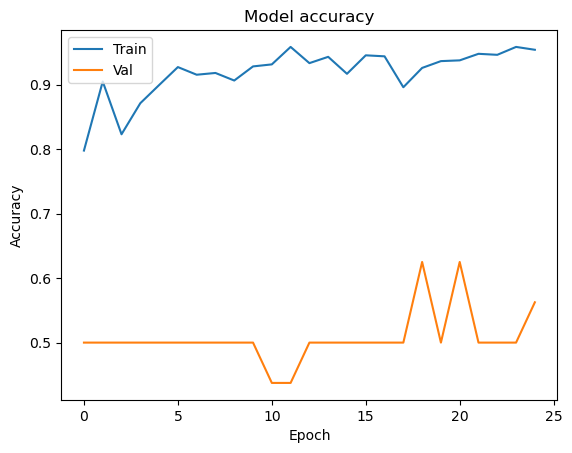

In [13]:
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Train', 'Val'], loc='upper left')  
plt.show() 

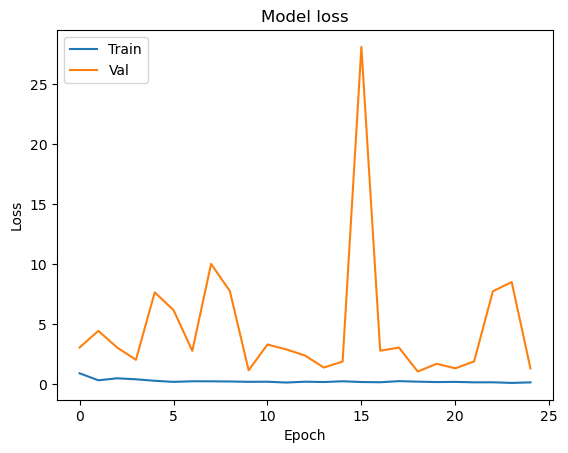

In [14]:
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('Model loss')  
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left') 
plt.show() 

## 5. Model Evaluation

In [15]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.8697 - loss: 0.3940
Test Accuracy: 0.7211538553237915
Test Loss: 0.711718738079071


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 302ms/step


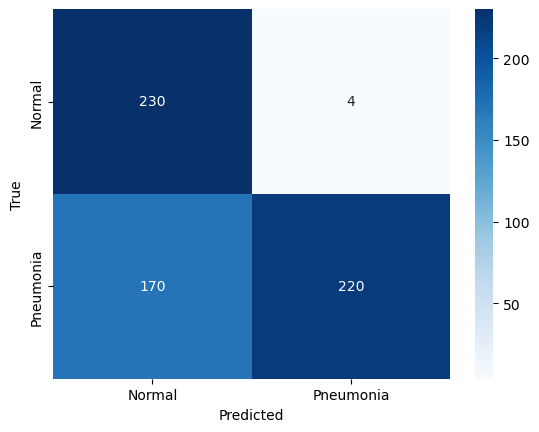

In [16]:
# Confusion Matrix
test_predictions = model.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)

cm = confusion_matrix(test_generator.classes, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [17]:
# Classification Report
print(classification_report(test_generator.classes, test_predictions, target_names=['NORMAL', 'PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.57      0.98      0.73       234
   PNEUMONIA       0.98      0.56      0.72       390

    accuracy                           0.72       624
   macro avg       0.78      0.77      0.72       624
weighted avg       0.83      0.72      0.72       624



## 6. Testing

In [18]:
# Load and preprocess the image
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

#### Normal Image

In [19]:
image_path = r"/Users/bhushannimje/Documents/Company/Scifor Technologies/Major Project/Pneumonia Detection from Chest X-Rays Using Deep Learning/chest_xray/test/NORMAL/IM-0016-0001.jpeg" 
img = load_img(image_path, target_size=(224, 224))

In [20]:
# Convert to array and normalize pixel values
img = img_to_array(img)
img = img / 255.0  
img = np.expand_dims(img, axis=0)

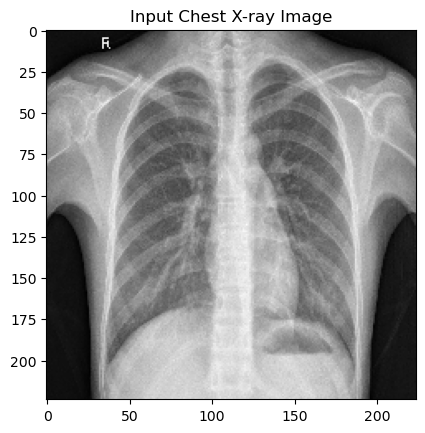

In [21]:
# Show the preprocessed image
plt.imshow(np.uint8(img[0] * 255))  # Convert back to [0, 255] range for display
plt.title('Input Chest X-ray Image')
plt.show()

In [22]:
# Make a prediction
rslt = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step


In [23]:
# Interpreting the result
# Assuming the model outputs 0 for NORMAL and 1 for PNEUMONIA
if rslt[0][0] > 0.5:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"

# Print the prediction
print(f"Prediction: {prediction}")

# Probability score
print(f"Model Output (Probability): {rslt[0][0]}")

Prediction: NORMAL
Model Output (Probability): 0.022234972566366196


#### Pneumonia Image

In [24]:
image_path = r"/Users/bhushannimje/Documents/Company/Scifor Technologies/Major Project/Pneumonia Detection from Chest X-Rays Using Deep Learning/chest_xray/test/PNEUMONIA/person1_virus_9.jpeg"
img = load_img(image_path, target_size=(224, 224))

In [25]:
# Convert to array and normalize pixel values
img = img_to_array(img)
img = img / 255.0  
img = np.expand_dims(img, axis=0)

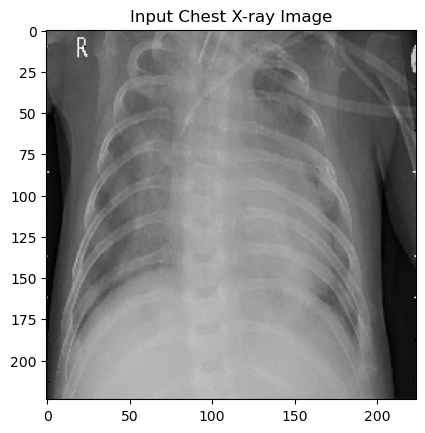

In [26]:
# Show the preprocessed image
plt.imshow(np.uint8(img[0] * 255))  # Convert back to [0, 255] range for display
plt.title('Input Chest X-ray Image')
plt.show()

In [27]:
# Make a prediction
rslt = model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [28]:
# Interpreting the result
# Assuming the model outputs 0 for NORMAL and 1 for PNEUMONIA
if rslt[0][0] > 0.5:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"

# Print the prediction
print(f"Prediction: {prediction}")

# Probability score
print(f"Model Output (Probability): {rslt[0][0]}")

Prediction: PNEUMONIA
Model Output (Probability): 0.979705274105072


## Model Development with Transfer Learning

In [29]:
# Function to build a model using transfer learning
def build_model(base_model):
    model_transfer_learning = Sequential([
        base_model,
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    return model

In [30]:
# List of pre-trained models to compare
from tensorflow.keras.applications import VGG16, VGG19, ResNet50, InceptionV3

# Load the model with locally stored weights
local_weights_file = r'/Users/bhushannimje/Documents/Company/Scifor Technologies/Major Project/Pneumonia Detection from Chest X-Rays Using Deep Learning/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_model = VGG16(weights=local_weights_file, include_top=False, input_shape=(224, 224, 3))

pretrained_models = [
    vgg_model,
    VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3)),
    InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
]

In [31]:
model_names = ['VGG16', 'VGG19', 'ResNet50', 'InceptionV3']
results = {}

In [32]:
for model_name, base_model in zip(model_names, pretrained_models):
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False

In [33]:
# Build the full model
model_transfer_learning = build_model(base_model)

In [34]:
# Compile the model
model_transfer_learning.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Training with Transfer Learning Model

In [35]:
history = model_transfer_learning.fit(train_generator, 
                        epochs=25, 
                        validation_data=val_generator)

Epoch 1/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.8876 - loss: 0.3895 - val_accuracy: 0.4375 - val_loss: 39.1952
Epoch 2/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9092 - loss: 0.2599 - val_accuracy: 0.5000 - val_loss: 1.8795
Epoch 3/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9254 - loss: 0.2132 - val_accuracy: 0.4375 - val_loss: 3.3071
Epoch 4/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9389 - loss: 0.1694 - val_accuracy: 0.5625 - val_loss: 2.1198
Epoch 5/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - accuracy: 0.9267 - loss: 0.2061 - val_accuracy: 0.5625 - val_loss: 1.2688
Epoch 6/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9316 - loss: 0.1725 - val_accuracy: 0.5000 - val_loss: 7.9895
Epoch 7/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9132 - loss: 0.2446 - val_accuracy: 0.4375 - val_loss: 3.5757
Epoch 8/25
163/163 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - accuracy: 0.9478 - loss: 0.1466 - val_acc

In [36]:
history.history

{'accuracy': [0.8964723944664001,
  0.9081671833992004,
  0.9298312664031982,
  0.9319401979446411,
  0.9294478297233582,
  0.9342408180236816,
  0.9263803958892822,
  0.9426763653755188,
  0.949769914150238,
  0.9468941688537598,
  0.9551380276679993,
  0.9482361674308777,
  0.9491947889328003,
  0.9574386477470398,
  0.9597392678260803,
  0.9537960290908813,
  0.9597392678260803,
  0.9587806463241577,
  0.9144938588142395,
  0.9415260553359985,
  0.9589723944664001,
  0.9223542809486389,
  0.9432515501976013,
  0.9476610422134399,
  0.9451687335968018],
 'loss': [0.3488984704017639,
  0.2697402536869049,
  0.19534854590892792,
  0.18352164328098297,
  0.19612401723861694,
  0.17417724430561066,
  0.20013689994812012,
  0.1517460197210312,
  0.15025730431079865,
  0.14854177832603455,
  0.12646707892417908,
  0.13460737466812134,
  0.13411679863929749,
  0.11431855708360672,
  0.11299894005060196,
  0.13535313308238983,
  0.10824798047542572,
  0.11182469129562378,
  0.249503716826438

### Performance Graph

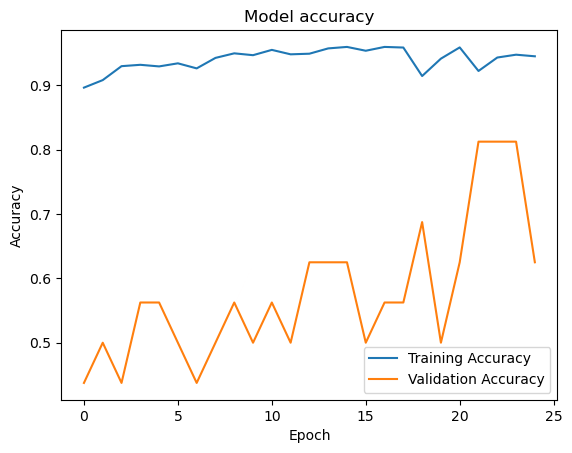

In [37]:
plt.plot(history.history['accuracy'])  # Plot training accuracy
plt.plot(history.history['val_accuracy'])  # Plot validation accuracy
plt.title('Model accuracy')
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')  
plt.show() 

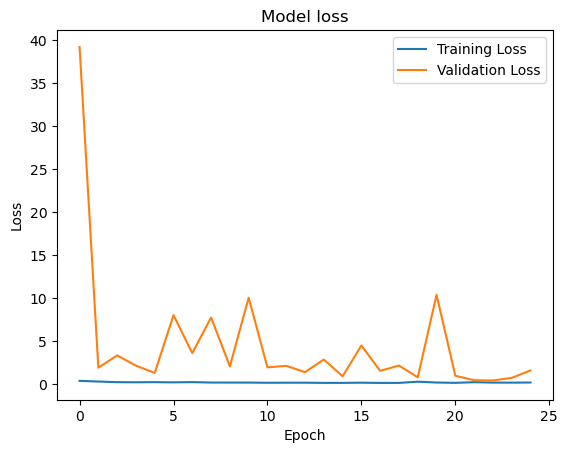

In [38]:
plt.plot(history.history['loss'])  # Plot training loss
plt.plot(history.history['val_loss'])  # Plot validation loss
plt.title('Model loss')  
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right') 
plt.show()

### Model Evaluation of Transfer Learning Model

In [39]:
# Evaluate the model on the test set
test_loss, test_acc = model_transfer_learning.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")
print(f"Test Loss: {test_loss}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.5623 - loss: 1.3398
Test Accuracy: 0.7371794581413269
Test Loss: 0.8293105959892273


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step


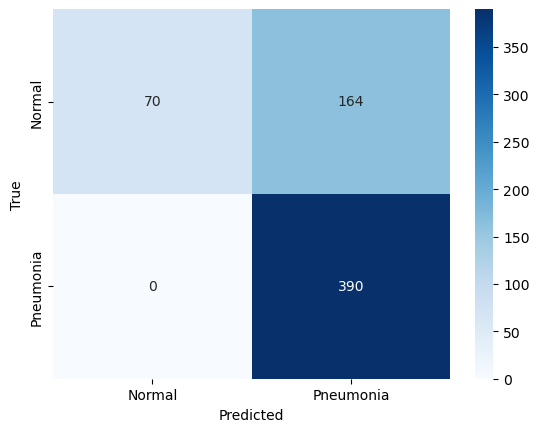

In [40]:
# Confusion Matrix
test_predictions = model_transfer_learning.predict(test_generator)
test_predictions = (test_predictions > 0.5).astype(int)

cm = confusion_matrix(test_generator.classes, test_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [41]:
# Generate classification report
y_true = test_generator.classes
y_pred = model_transfer_learning.predict(test_generator) > 0.5
print(f"Classification Report for {model_name}:\n")
print(classification_report(y_true, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step
Classification Report for InceptionV3:

              precision    recall  f1-score   support

           0       1.00      0.30      0.46       234
           1       0.70      1.00      0.83       390

    accuracy                           0.74       624
   macro avg       0.85      0.65      0.64       624
weighted avg       0.81      0.74      0.69       624



### Testing of Transfer Learning Model

#### Normal Image

In [42]:
image_path = r"/Users/bhushannimje/Documents/Company/Scifor Technologies/Major Project/Pneumonia Detection from Chest X-Rays Using Deep Learning/chest_xray/test/NORMAL/IM-0016-0001.jpeg" 
img = load_img(image_path, target_size=(224, 224))

In [43]:
# Convert to array and normalize pixel values
img = img_to_array(img)
img = img / 255.0  
img = np.expand_dims(img, axis=0)

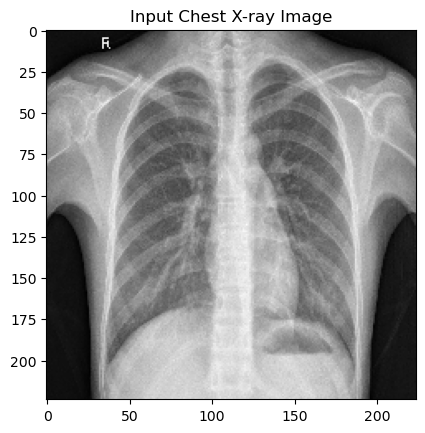

In [44]:
# Show the preprocessed image
plt.imshow(np.uint8(img[0] * 255))  # Convert back to [0, 255] range for display
plt.title('Input Chest X-ray Image')
plt.show()

In [45]:
# Make a prediction
rslt = model_transfer_learning.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


In [46]:
# Interpreting the result
# Assuming the model outputs 0 for NORMAL and 1 for PNEUMONIA
if rslt[0][0] > 0.5:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"

# Print the prediction
print(f"Prediction: {prediction}")

# Probability score
print(f"Model Output (Probability): {rslt[0][0]}")

Prediction: NORMAL
Model Output (Probability): 0.35551631450653076


#### Pneumonia Image

In [47]:
image_path = r"/Users/bhushannimje/Documents/Company/Scifor Technologies/Major Project/Pneumonia Detection from Chest X-Rays Using Deep Learning/chest_xray/test/PNEUMONIA/person1_virus_9.jpeg"
img = load_img(image_path, target_size=(224, 224))

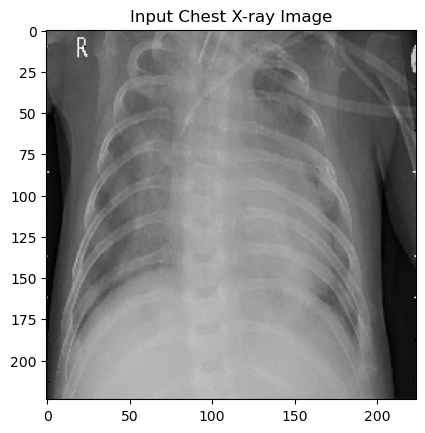

In [48]:
# Convert to array and normalize pixel values
img = img_to_array(img)
img = img / 255.0  
img = np.expand_dims(img, axis=0)

# Show the preprocessed image
plt.imshow(np.uint8(img[0] * 255))  # Convert back to [0, 255] range for display
plt.title('Input Chest X-ray Image')
plt.show()

In [49]:
# Make a prediction
rslt = model_transfer_learning.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [50]:
# Interpreting the result
# Assuming the model outputs 0 for NORMAL and 1 for PNEUMONIA
if rslt[0][0] > 0.5:
    prediction = "PNEUMONIA"
else:
    prediction = "NORMAL"

# Print the prediction
print(f"Prediction: {prediction}")

# Probability score
print(f"Model Output (Probability): {rslt[0][0]}")

Prediction: PNEUMONIA
Model Output (Probability): 0.9999164342880249
